## Семинар 9: "LSTM"

ФИО: Бабаков Вадим Валерьевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import pandas
from sklearn.preprocessing import MinMaxScaler
import sys
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden = None):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        if hidden is None:
            h = Variable(torch.zeros(self.hidden_size, inputs.size(0)), requires_grad=False)
            c = Variable(torch.zeros(self.hidden_size, inputs.size(0)), requires_grad=False)
        else:
            h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

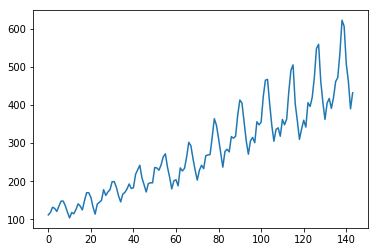

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

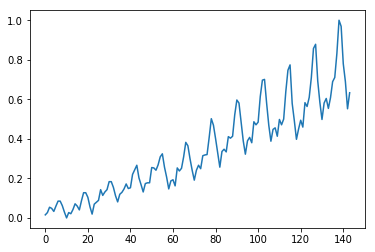

In [5]:
plt.plot(dataset)

In [6]:
# разбиваем данные на train / test
train_part = 0.67
train_size = int(len(dataset) * train_part)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [7]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [8]:
# Пример подготовленных данных

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
class PassengerDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
class LSTM_Wrapper(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM_Wrapper, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # LSTM ceil
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim)
        
        # Linear layer which transforms LSTM ceil' output 
        # of size hidden_dim to output of size output_dim
        self.outNN = nn.Sequential(
            nn.Linear(self.hidden_dim, self.output_dim)
        )
    
    # @X is a Variable with dims [batch_num, seq_len, input_dim]
    # result of forward is a Variable with dims [batch_num, seq_len, output_dim]
    def forward(self, X):
        X = X.clone()
        # LSTM input is a Variable with dims [seq_len, batch_num, input_dim]
        # LSTM output is a Variable with dims [seq_len, batch_num, hidden_dim]
        X = X.permute(1, 0, 2)
        output, (self.H, self.C) = self.lstm(X)
        output = output.permute(1, 0, 2)
        output = self.outNN(output)
        return output

In [11]:
def init_params(network):
    for name, param in network.named_parameters():
        if 'b' in name:
            nn.init.constant(param, 0.0)
        elif 'w' in name:
            nn.init.xavier_normal(param)

In [12]:
def train_func(network, loss, optimizer, scheduler, dataloader, epochs, look_back):
    epoch_losses = []
    try:
        for epoch in range(epochs):
            for X, y in dataloader:
                batch_losses = []
                
                X = Variable(X).view(X.shape[0], look_back, -1)
                y = Variable(y).view(X.shape[0], 1, 1)

                network.zero_grad()

                predictions = network(X)
                loss_value = loss(predictions, y)
                loss_value.backward()
                optimizer.step()

                batch_losses.append(loss_value.cpu().data)
            epoch_losses.append(np.mean(batch_losses))
            scheduler.step()
            if epoch % 10 == 0:
                sys.stdout.write('\rEpoch {0}... (Train) MSE: {1:.10f}'.format(epoch, epoch_losses[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(epoch_losses, label='Losses')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [14]:
def predict(network, seq_begin, prediction_len):
    result = np.zeros(seq_begin.shape[0] + prediction_len)
    result[:seq_begin.shape[0]] = seq_begin
    for _ in range(prediction_len):
        X = Variable(torch.Tensor(result[_:_ + seq_begin.shape[0]])).view(1, seq_begin.shape[0], -1)
        p = network(X)
        result[_ + seq_begin.shape[0]] = p[0, -1, 0]
    return result[seq_begin.shape[0]:]

In [15]:
# Returns [network, optimizer, scheduler, loss, dataloader]
def make_train_eval_model(lstm_type, look_back, hidden_dim, epochs):
    net = None
    if lstm_type == 'custоm':
        net = LSTM(1, hidden_dim)
    else:
        net = LSTM_Wrapper(1, hidden_dim, 1)

    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), 0.01)
    scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

    trainX, trainY = create_dataset(train, look_back)
    dataset = PassengerDataset(trainX, trainY)
    dataloader = DataLoader(dataset, shuffle=True, batch_size=64)
    
    if lstm_type == 'custоm':
        for_my_train_func(*(net, loss, optimizer, scheduler, dataloader), epochs=epochs, look_back=look_back)
    else:
        train_func(*(net, loss, optimizer, scheduler, dataloader), epochs=epochs, look_back=look_back)
    
    start = 0
    end = start + look_back
    pred_len = 100
    seq = train[:,0]

    seq_begin = seq[start:end]
    pred = predict(net, seq_begin, pred_len)

    result_real = seq[start:end+pred_len]
    result_pred = np.append(seq_begin, pred)
    plt.plot(result_real, label='actual')
    plt.plot(result_pred, label='predicted')

    plt.legend(fontsize=14)

Epoch 990... (Train) MSE: 0.0030911658

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


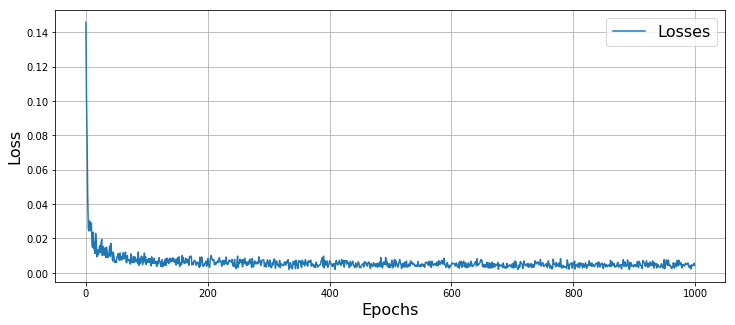

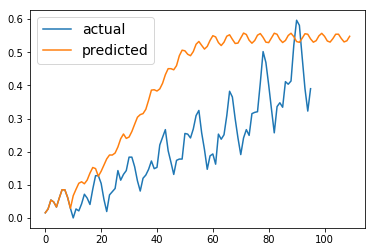

In [28]:
make_train_eval_model('custom', hidden_dim=10, look_back=10, epochs=1000)

Epoch 990... (Train) MSE: 0.0117818238

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


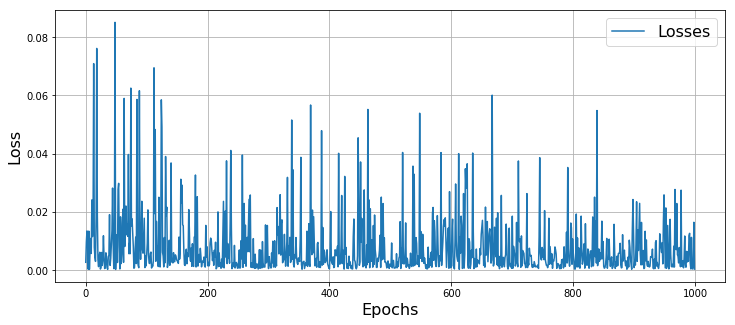

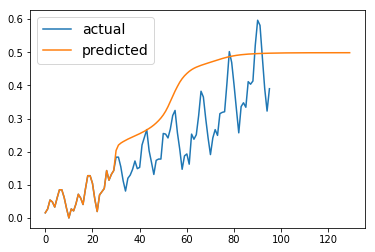

In [29]:
make_train_eval_model('custom', hidden_dim=20, look_back=30, epochs=1000)

Epoch 990... (Train) MSE: 0.0031137196

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


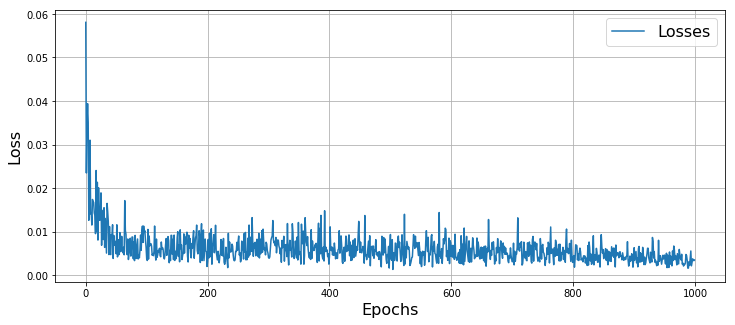

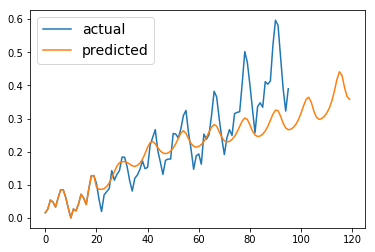

In [17]:
make_train_eval_model('ncustom', hidden_dim=10, look_back=20, epochs=1000)

Epoch 990... (Train) MSE: 0.0005975427

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


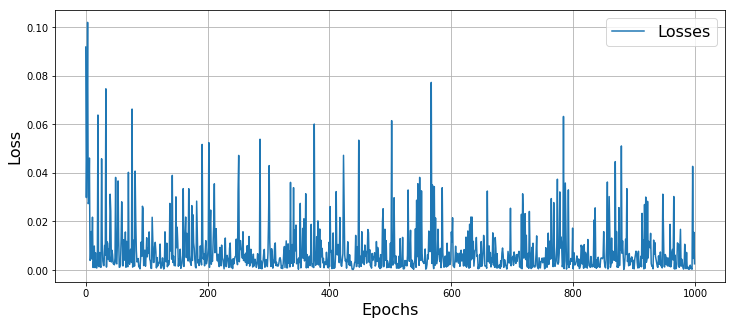

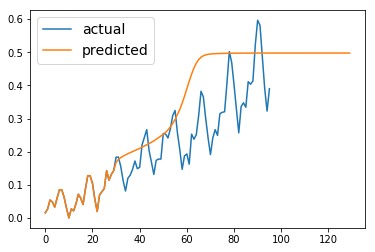

In [18]:
make_train_eval_model('non_custom', hidden_dim=10, look_back=30, epochs=1000)

Epoch 990... (Train) MSE: 0.0026555911

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


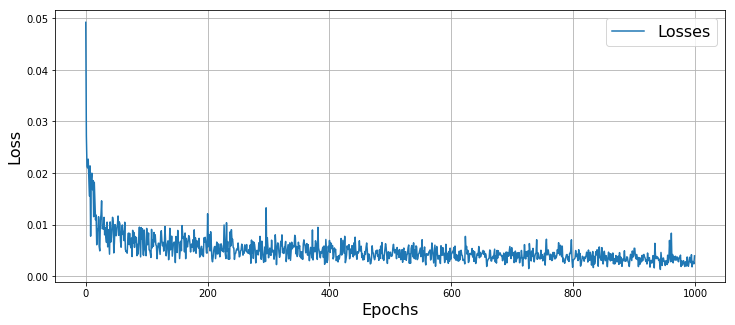

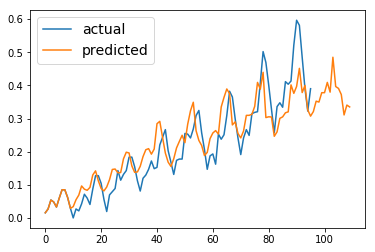

In [19]:
make_train_eval_model('non_custom', hidden_dim=20, look_back=10, epochs=1000)

Epoch 990... (Train) MSE: 0.0039596423

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


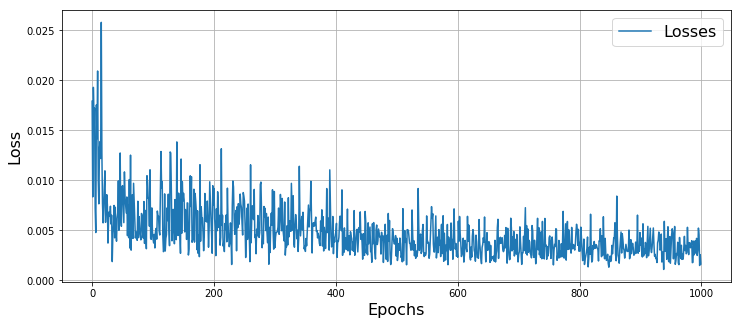

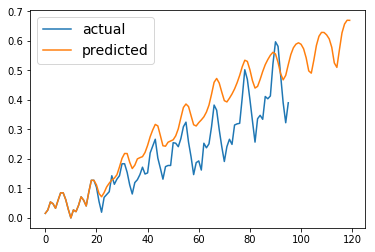

In [20]:
make_train_eval_model('non_custom', hidden_dim=20, look_back=20, epochs=1000)

Epoch 990... (Train) MSE: 0.0099562733

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


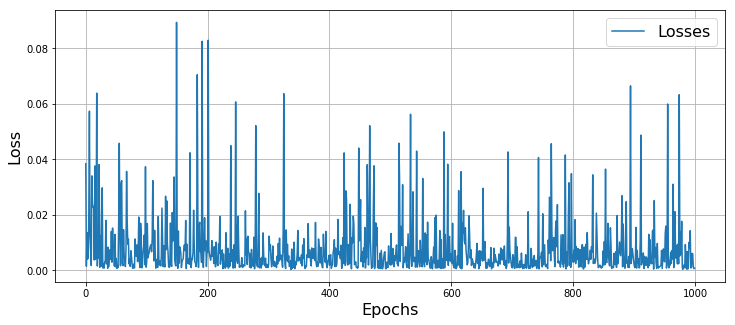

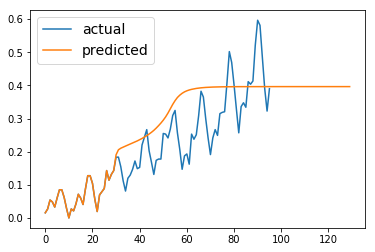

In [21]:
make_train_eval_model('non_custom', hidden_dim=20, look_back=30, epochs=1000)

Epoch 990... (Train) MSE: 0.0046431660

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


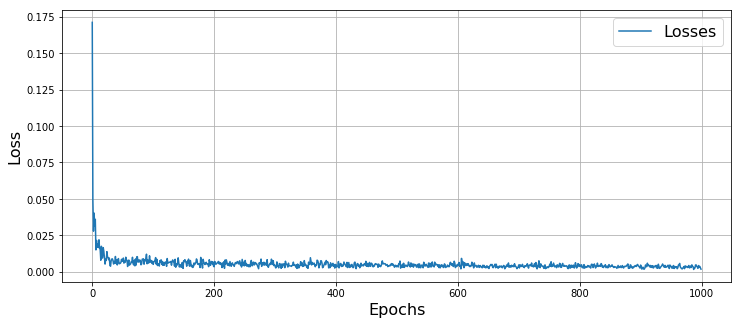

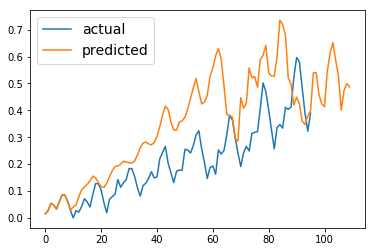

In [22]:
make_train_eval_model('non_custom', hidden_dim=30, look_back=10, epochs=1000)

Epoch 990... (Train) MSE: 0.0033056731

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


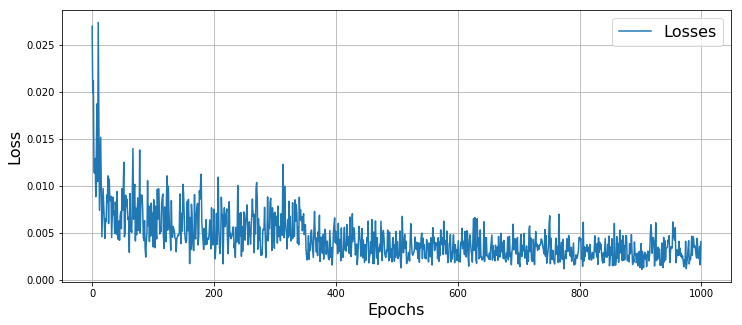

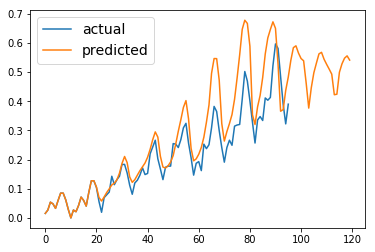

In [23]:
make_train_eval_model('non_custom', hidden_dim=30, look_back=20, epochs=1000)

Epoch 4950... (Train) MSE: 0.0008247976

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


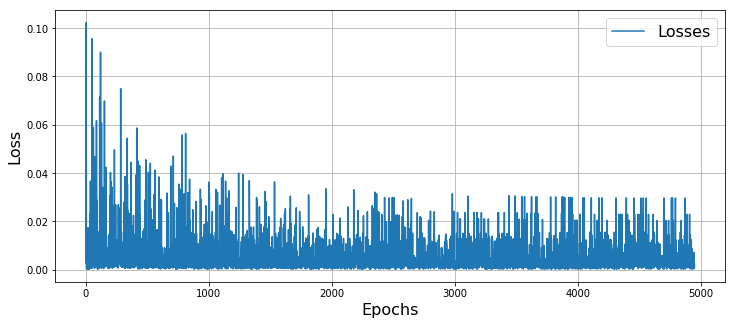

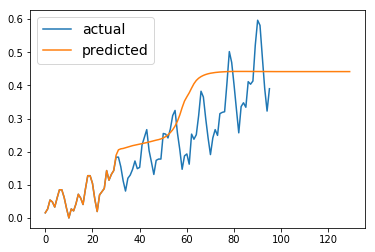

In [24]:
make_train_eval_model('non_custom', hidden_dim=30, look_back=30, epochs=10000)

Epoch 4990... (Train) MSE: 0.0009376256

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


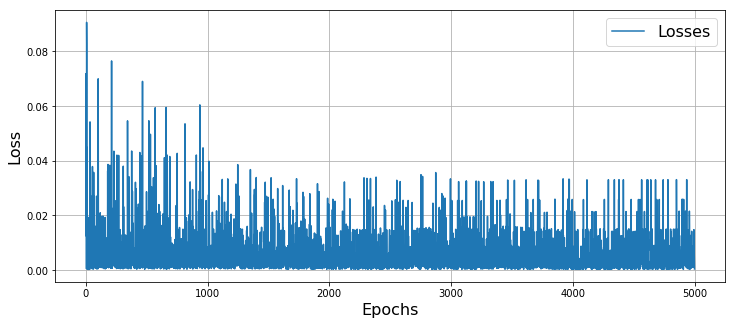

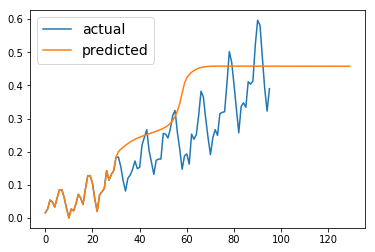

In [25]:
make_train_eval_model('non_custom', hidden_dim=40, look_back=30, epochs=5000)

Epoch 990... (Train) MSE: 0.0008048650

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


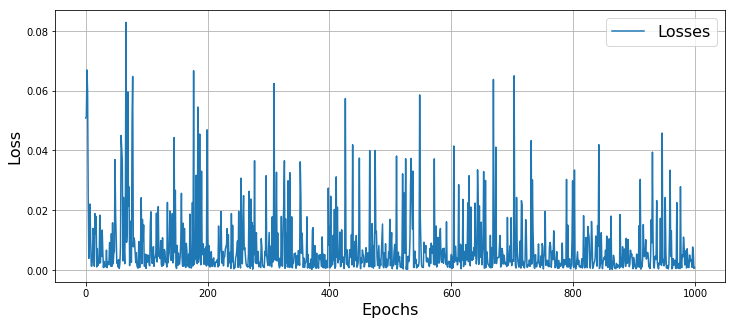

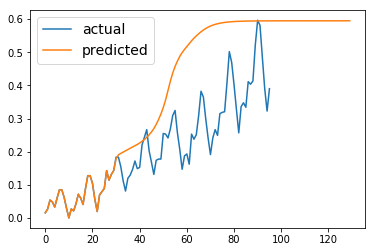

In [26]:
make_train_eval_model('non_custom', hidden_dim=40, look_back=60, epochs=1000)

В целом, предсказание по 20 точкам вышло оптимальным: модель хорошо улавливает структуру временного ряда и даёт неплохие результаты. В случае с длиной входной последовательности в >=30 модель перестаёт "ловить" структуру временного ряда, и предсказание с большим трудом можно назвать корректным.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: